# Grupo 15

* De Blasis, Cristian
* Gudiño, Gabriel
* Milich-Tear, Guillermo
* Veiga, Cristian

## Busqueda de modelos con Pycaret
En este notebook se analizaran distintos modelos con la librería pycarte a fin de encontrar los que mejores funcionan


In [ ]:
import pandas as pd
import pycaret
from sklearn.metrics import roc_auc_score
from pycaret.classification import *
import joblib
from sklearn import model_selection

import locale
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')
from datetime import datetime as dt


#Configuracion pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Prepara dataset para entrenamiento

### IMPORTANTE
Las features del dataset utilizado se obtivo como promedio de los vectores de cada palabra.


El archivo se puede descargar en https://drive.google.com/file/d/1K3pkC2p0Ah-bH8GPlCAoFqriH3emgxBG/view?usp=sharing

In [ ]:
df=joblib.load('./datasets/2_VECTOR_PROM')

In [ ]:
data=pd.DataFrame(df['vector_promedio'].to_list())
data['label']=df['topico'].values
data['fecha']=df['fecha'].values

# Se le especifica el tipo a las columnas
data['label']=data['label'].astype('category')
data['fecha']=data['fecha'].map(lambda s:dt.strptime(s, '%d de %B de %Y - %H:%M'))

# Separacion Train Test
En este trabajo se pretende evaluar el modelo ya sea con un dataset mezclado o con una separación cronologica. Para esto debemos "ecualizar" la cantidad de registros que quedan por seccion a fin de realizar una comparación justa


## Train-Test separados por fechas

In [ ]:
data=data.sort_values(by='fecha')
data.reset_index(drop=True,inplace=True)

In [ ]:
train_test_frac=0.8
rows=round(data.shape[0]*train_test_frac)
fecha_corte=data.loc[rows,'fecha']

train_date=data[data['fecha']<=fecha_corte].reset_index(drop=True)
test_date=data[data['fecha']>fecha_corte].reset_index(drop=True)

In [ ]:
print('FECHAS TRAIN:'+str(train_date['fecha'].min())+ '-'+str(train_date['fecha'].max()))
print('FECHAS TEST:'+str(test_date['fecha'].min())+ '-'+str(test_date['fecha'].max()))

FECHAS TRAIN:2018-03-08 01:59:00-2021-11-30 00:48:00
FECHAS TEST:2021-11-30 02:40:00-2022-08-31 11:04:00


### Registros por etiquetas en train

In [ ]:
train_date['label'].value_counts()

el-pais     8537
sociedad    8083
economia    5906
el-mundo    5117
Name: label, dtype: int64

### Registros por etiquetas en test

In [ ]:
test_date['label'].value_counts()

sociedad    2400
el-pais     2145
economia    1354
el-mundo    1007
Name: label, dtype: int64

## Train-Test mezclados

In [ ]:
train_shuffle, test_shuffle = model_selection.train_test_split(data, test_size=0.2,stratify=data['label'],random_state=2016,shuffle=True)

In [ ]:
print('FECHAS TRAIN:'+str(train_shuffle['fecha'].min())+ '-'+str(train_shuffle['fecha'].max()))
print('FECHAS TEST:'+str(test_shuffle['fecha'].min())+ '-'+str(test_shuffle['fecha'].max()))

FECHAS TRAIN:2018-03-08 01:59:00-2022-08-31 11:04:00
FECHAS TEST:2018-03-10 01:11:00-2022-08-31 07:23:00


In [ ]:
train_shuffle['label'].value_counts()

el-pais     8546
sociedad    8386
economia    5808
el-mundo    4899
Name: label, dtype: int64

In [ ]:
test_shuffle['label'].value_counts()

el-pais     2136
sociedad    2097
economia    1452
el-mundo    1225
Name: label, dtype: int64

**Se observa que las candtidades por seccion son diferentes en cada Train-Test por tal motivo se normalizará al valor mínimo**

## Normalización de cantidad de registros por secciones

In [ ]:
secciones=['economia','sociedad','el-mundo','el-pais']
train_date_norm=pd.DataFrame([],columns=train_date.columns)
test_date_norm=pd.DataFrame([],columns=train_date.columns)

train_shuffle_norm=pd.DataFrame([],columns=train_shuffle.columns)
test_shuffle_norm=pd.DataFrame([],columns=train_shuffle.columns)


for seccion in secciones:
    train_min=min(sum(train_date['label']==seccion),sum(train_shuffle['label']==seccion))
    test_min=min(sum(test_date['label']==seccion),sum(test_shuffle['label']==seccion))
    
    train_date_norm=pd.concat([train_date_norm,train_date[train_date['label']==seccion].sample(train_min)],axis=0)
    train_shuffle_norm=pd.concat([train_shuffle_norm,train_shuffle[train_shuffle['label']==seccion].sample(train_min)],axis=0)
    
    test_date_norm=pd.concat([test_date_norm,test_date[test_date['label']==seccion].sample(test_min)],axis=0)
    test_shuffle_norm=pd.concat([test_shuffle_norm,test_shuffle[test_shuffle['label']==seccion].sample(test_min)],axis=0)    

## Verifiacion dataset normalizados

### Separados cronologicamente

In [ ]:
print('FECHAS TRAIN:'+str(train_date_norm['fecha'].min())+ '-'+str(train_date_norm['fecha'].max()))
print('FECHAS TEST:'+str(test_date_norm['fecha'].min())+ '-'+str(test_date_norm['fecha'].max()))

FECHAS TRAIN:2018-03-08 01:59:00-2021-11-30 00:48:00
FECHAS TEST:2021-11-30 02:40:00-2022-08-31 11:04:00


In [ ]:
train_date_norm['label'].value_counts()

el-pais     8537
sociedad    8083
economia    5808
el-mundo    4899
Name: label, dtype: int64

In [ ]:
test_date_norm['label'].value_counts()

el-pais     2136
sociedad    2097
economia    1354
el-mundo    1007
Name: label, dtype: int64

### Separados al azar

In [ ]:
print('FECHAS TRAIN:'+str(train_shuffle_norm['fecha'].min())+ '-'+str(train_shuffle_norm['fecha'].max()))
print('FECHAS TEST:'+str(test_shuffle_norm['fecha'].min())+ '-'+str(test_shuffle_norm['fecha'].max()))

FECHAS TRAIN:2018-03-08 01:59:00-2022-08-31 11:04:00
FECHAS TEST:2018-03-10 01:11:00-2022-08-31 07:23:00


In [ ]:
train_shuffle_norm['label'].value_counts()

el-pais     8537
sociedad    8083
economia    5808
el-mundo    4899
Name: label, dtype: int64

In [ ]:
test_shuffle_norm['label'].value_counts()

el-pais     2136
sociedad    2097
economia    1354
el-mundo    1007
Name: label, dtype: int64

**Ahora vemos que las proporciones son las mismas, lo cual permitirá una justa comparación**


# Prueba de varios modelos

Se utilizará una libreria de auto ML para verificar distintos modelos de manera práctica y rápida. 

https://www.kaggle.com/code/pralabhpoudel/multiclass-classification-with-automl-pycaret

In [ ]:
exp_clf101 = setup(data = train_date_norm.drop(columns=['fecha']), target = 'label',train_size = 0.7,fold=3,fold_shuffle=True,fold_strategy='kfold',session_id=1001)

In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8350,0.9618,0.8369,0.8360,0.8352,0.7759,0.7761,80.2800
xgboost,Extreme Gradient Boosting,0.8297,0.9608,0.8314,0.8309,0.8299,0.7686,0.7688,135.2733
lr,Logistic Regression,0.8289,0.9579,0.8321,0.8297,0.8291,0.7677,0.7678,3.4933
svm,SVM - Linear Kernel,0.8279,0.0000,0.8304,0.8293,0.8281,0.7662,0.7665,0.4733
lightgbm,Light Gradient Boosting Machine,0.8264,0.9594,0.8279,0.8278,0.8267,0.7641,0.7644,10.4167
ridge,Ridge Classifier,0.8243,0.0000,0.8273,0.8254,0.8246,0.7614,0.7616,0.1600
lda,Linear Discriminant Analysis,0.8237,0.9538,0.8269,0.8254,0.8242,0.7604,0.7605,0.7000
gbc,Gradient Boosting Classifier,0.8126,0.9517,0.8152,0.8140,0.8129,0.7454,0.7456,171.1567
knn,K Neighbors Classifier,0.8090,0.9380,0.8117,0.8147,0.8087,0.7405,0.7428,4.5067
rf,Random Forest Classifier,0.8033,0.9466,0.8003,0.8084,0.8036,0.7318,0.7330,2.6333


La métrica a la que se le prestará atención es al **AUC, one vs Rest** tal como se vio en los ejercicios de ejemplo. Algo que se observa es que si bien SVM funciono relativamente bien para Accuracy no se observan valores para AUC. Esto se debe a que pycaret no soporta la funcion predict_proba para SVM tal como se menciona en https://pycaret.readthedocs.io/en/stable/api/classification.html
.Por tal motivo se realizará una nueva notebook **3_clasificador_SVM.ipynb** a fin de generar específicamente este modelo


# Performance de los mejores en Test

En esta sección se eligen los mejores modelos y se los prueba en el dataset Test a fin de decidir cual es el mejor en datos que nunca uso para el entrenamiento.


In [ ]:
model_cb = create_model('catboost')
model_lgb = create_model('lightgbm')
model_lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8298,0.9610,0.8316,0.8311,0.8301,0.7688,0.7691
1,0.8290,0.9591,0.8309,0.8309,0.8295,0.7682,0.7685
2,0.8308,0.9603,0.8323,0.8319,0.8309,0.7695,0.7697
Mean,0.8299,0.9601,0.8316,0.8313,0.8302,0.7688,0.7691
SD,0.0007,0.0008,0.0006,0.0004,0.0006,0.0005,0.0005


## Performance CatBoost  - Test set

In [ ]:
pred_cb = predict_model(model_cb, data=test_date_norm)

secciones=['economia','sociedad','el-pais','el-mundo']
auc_list=[]

for inx,seccion in enumerate(secciones):
    auc_list.append(roc_auc_score((pred_cb['label']==seccion).astype(int),(pred_cb['Label']==seccion).astype(int)))
    print(seccion+" AUC: "+ str(auc_list[inx]))
print("AUC ovr: "+str(sum(auc_list)/4))

economia AUC: 0.929512217123141
sociedad AUC: 0.8949851482612953
el-pais AUC: 0.8778401787469566
el-mundo AUC: 0.9144095857367854
AUC ovr: 0.9041867824670445


## Performance Light Gradient Boosting Machine  -  Test set

In [ ]:
pred_lgb = predict_model(model_lgb, data=test_date_norm)

secciones=['economia','sociedad','el-pais','el-mundo']
auc_list=[]

for inx,seccion in enumerate(secciones):
    auc_list.append(roc_auc_score((pred_lgb['label']==seccion).astype(int),(pred_lgb['Label']==seccion).astype(int)))
    print(seccion+" AUC: "+ str(auc_list[inx]))
print("AUC ovr: "+str(sum(auc_list)/4))

economia AUC: 0.9230932943948944
sociedad AUC: 0.8914272207540681
el-pais AUC: 0.8685014567927372
el-mundo AUC: 0.9050333009900804
AUC ovr: 0.897013818232945


## Performance Logistic Regression  -  Test set

In [ ]:
pred_lr = predict_model(model_lr, data=test_date_norm)

secciones=['economia','sociedad','el-pais','el-mundo']
auc_list=[]

for inx,seccion in enumerate(secciones):
    auc_list.append(roc_auc_score((pred_lr['label']==seccion).astype(int),(pred_lr['Label']==seccion).astype(int)))
    print(seccion+" AUC: "+ str(auc_list[inx]))
print("AUC ovr: "+str(sum(auc_list)/4))


economia AUC: 0.9206619910471658
sociedad AUC: 0.8873243424403425
el-pais AUC: 0.8717493106698726
el-mundo AUC: 0.9163724876286613
AUC ovr: 0.8990270329465105


In [ ]:
print(model_cb)

# Entrenamiento final del modelo
Aqui se lo entrena con todo el dataset de trian (train + validacion) y se deja el test para evaluacion

Se realiza una optimizacion de hiperparametros mediante grid search

### Tunned LR

In [ ]:
# tuned_lgb = tune_model(model_lgb,custom_grid = {'num_leaves' : np.arange(20,50,1)})
model_lr = create_model('lr')
tuned_lr = tune_model(model_lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8363,0.9607,0.8415,0.8365,0.8364,0.7780,0.7780
1,0.8275,0.9583,0.8328,0.8282,0.8277,0.7665,0.7666
2,0.8294,0.9580,0.8339,0.8299,0.8296,0.7678,0.7679
Mean,0.8310,0.9590,0.8361,0.8316,0.8312,0.7708,0.7708
SD,0.0038,0.0012,0.0039,0.0036,0.0037,0.0051,0.0051


In [ ]:
final_lr = finalize_model(tuned_lr)
pred_lr = predict_model(final_lr, data=test_date_norm)

secciones=['economia','sociedad','el-pais','el-mundo']
auc_list=[]

for inx,seccion in enumerate(secciones):
    auc_list.append(roc_auc_score((pred_lr['label']==seccion).astype(int),(pred_lr['Label']==seccion).astype(int)))
    print(seccion+" AUC: "+ str(auc_list[inx]))
print("AUC ovr: "+str(sum(auc_list)/4))

economia AUC: 0.9228070348529097
sociedad AUC: 0.8854477138311568
el-pais AUC: 0.8817660209395053
el-mundo AUC: 0.924080212452336
AUC ovr: 0.9035252455189768


# Evaluación final del modelo

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
confusion = confusion_matrix(pred_lr['label'], pred_lr['Label'])

In [ ]:
# Cantidad de registros por clase real
pred_lr['label'].value_counts()

el-pais     2136
sociedad    2097
economia    1354
el-mundo    1007
Name: label, dtype: int64

In [ ]:
# Cantidad de registros por clase predicha
pred_lr['Label'].value_counts()

el-pais     2085
sociedad    2033
economia    1413
el-mundo    1063
Name: Label, dtype: int64

<AxesSubplot:>

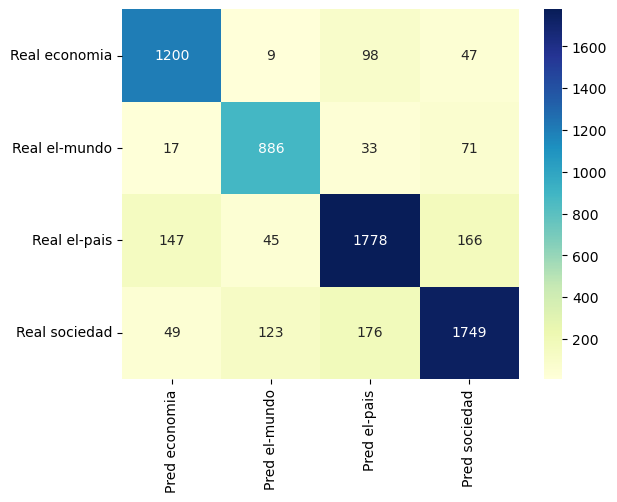

In [ ]:
cm_matrix = pd.DataFrame(data=confusion, columns=['Pred economia', 'Pred el-mundo','Pred el-pais','Pred sociedad'], 
                                 index=['Real economia', 'Real el-mundo','Real el-pais','Real sociedad'])
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap='YlGnBu')

In [ ]:
## Matriz de confusion normalizada con valores predichos (precisión)

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(pred_lr['label'], pred_lr['Label'], target_names=['economia', 'el-mundo', 'el-pais','sociedad']))
# pred_lr['label'].value_counts() #Sirve para chequear las clases


Classification Report

              precision    recall  f1-score   support

    economia       0.85      0.89      0.87      1354
    el-mundo       0.83      0.88      0.86      1007
     el-pais       0.85      0.83      0.84      2136
    sociedad       0.86      0.83      0.85      2097

    accuracy                           0.85      6594
   macro avg       0.85      0.86      0.85      6594
weighted avg       0.85      0.85      0.85      6594



# Evaluacion con dataset mezclado

In [ ]:
exp_clf101 = setup(data = train_shuffle_norm.drop(columns=['fecha']), target = 'label',train_size = 0.7,fold=3,fold_shuffle=True,fold_strategy='kfold',session_id=1001)

,Description,Value
0,session_id,1001
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,"economia: 0, el-mundo: 1, el-pais: 2, sociedad: 3"
4,Original Data,"(27327, 301)"
5,Missing Values,False
6,Numeric Features,300
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [ ]:
model_lr_s = create_model('lr')
tuned_lr_s = tune_model(model_lr_s)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8367,0.9633,0.8398,0.8375,0.8370,0.7783,0.7784
1,0.8405,0.9624,0.8455,0.8408,0.8406,0.7842,0.7842
2,0.8385,0.9608,0.8447,0.8384,0.8383,0.7806,0.7807
Mean,0.8386,0.9622,0.8433,0.8389,0.8386,0.7810,0.7811
SD,0.0015,0.0010,0.0025,0.0014,0.0015,0.0024,0.0024


In [ ]:
final_lr_s = finalize_model(tuned_lr_s)
pred_lr_s = predict_model(final_lgb, data=test_date_norm)

secciones=['economia','sociedad','el-pais','el-mundo']
auc_list=[]

for inx,seccion in enumerate(secciones):
    auc_list.append(roc_auc_score((pred_lr_s['label']==seccion).astype(int),(pred_lr_s['Label']==seccion).astype(int)))
    print(seccion+" AUC: "+ str(auc_list[inx]))
print("AUC ovr: "+str(sum(auc_list)/4))

economia AUC: 0.9305036251085278
sociedad AUC: 0.8998316474216002
el-pais AUC: 0.8845261769020218
el-mundo AUC: 0.9213523058298373
AUC ovr: 0.9090534388154968


### Evaluacion

<AxesSubplot:>

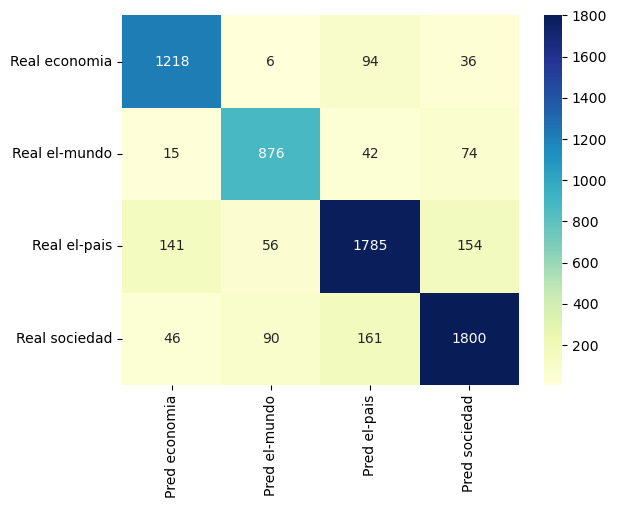

In [ ]:
confusion = confusion_matrix(pred_lr_s['label'], pred_lr_s['Label'])

cm_matrix = pd.DataFrame(data=confusion, columns=['Pred economia', 'Pred el-mundo','Pred el-pais','Pred sociedad'], 
                                 index=['Real economia', 'Real el-mundo','Real el-pais','Real sociedad'])
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(pred_lr_s['label'], pred_lr_s['Label'], target_names=['economia', 'el-mundo', 'el-pais','sociedad']))
# pred_lr['label'].value_counts() #Sirve para chequear las clases


Classification Report

              precision    recall  f1-score   support

    economia       0.86      0.90      0.88      1354
    el-mundo       0.85      0.87      0.86      1007
     el-pais       0.86      0.84      0.85      2136
    sociedad       0.87      0.86      0.87      2097

    accuracy                           0.86      6594
   macro avg       0.86      0.87      0.86      6594
weighted avg       0.86      0.86      0.86      6594

